## Introduction

In this project, we are going to study the practical side of multinomial Naive Bayes algorithm by building a spam filter for SMS messages to classify messages as spam or non-spam.

What is this algorithm all about?
Naive Bayes algorithm  makes the computer learn from the classification a humans does, and then the computer uses that knowledge to make classifications.

To classify messages as spam or non-spam, the computer:

1. Learns how humans classify messages.
2. Uses that human knowledge to estimate probabilities for new messages — probabilities for spam and non-spam.
3. Classifies a new message based on these probability values — if the probability for spam is greater, then it classifies the message as spam. Otherwise, it classifies it as non-spam (if the two probability values are equal, then we may need a human to classify the message).

So now, our first task is to "teach" the computer how to classify messages. To do it, we will use the multinomial Naive Bayes algorithm along with a dataset of 5,572 SMS messages that are already classified by humans.

## Exploring the dataset

The dataset was put together by Tiago A. Almeida and José María Gómez Hidalgo, and it can be downloaded from the [The UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection). We can also download the dataset directly [from this link](https://dq-content.s3.amazonaws.com/433/SMSSpamCollection). The data collection process is described in more details on [this page](http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/), where you can also find some of the authors' papers.
Let's start by reading in the dataset.

In [1]:
# Open the file 
# Note the data points are tab seperated
# The dataset does not have a header row. 
# Use header=None, otherwise the first row will be wrongly used as the header row

import pandas as pd
sms_spam = pd.read_csv("SMSSpamCollection", sep="\t", header=None, names=['Label', 'SMS'])

In [2]:
sms_spam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
Label    5572 non-null object
SMS      5572 non-null object
dtypes: object(2)
memory usage: 87.1+ KB


In [3]:
sms_spam.shape

(5572, 2)

In [4]:
sms_spam.describe()

,Label,SMS
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [5]:
sms_spam["Label"].value_counts(normalize=True)

ham     0.865937
spam    0.134063
Name: Label, dtype: float64

In [6]:
sms_spam.head()

,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


So, as we explore the dataset a little, we see the dataset shape (5572, 2). Meaning it has 5572 rows and 2 columns.
86.5% of the messages is ham(non-spam) and 13% of the messages is spam.

## Goal of this project

The goal of this project is to create a spam filter that classifies new messages with an accuracy greater that 80%. So the expectation is that more than 80% of the new messages will be classified correctly as spam and ham(non-spam).

## Splitting the dataset into training and test set

First let us split our dataset into two categories. First category is for training the computer how to classify messages and another one for testing how good the spam filter is with classifying new messages.

- Training set: 80% of our dataset
- Test Set: 20% of our dataset

That is, 

- Total SMS messages = 5,572
- Training Set = 4,458 
- Test Set = 1,114

In [7]:
# Let us start by randomizing the entire dataset
# Use the frac=1 parameter to randomize the entire dataset
# Use the random_state=1 parameter to make sure your results are reproducible

randomized_data = sms_spam.sample(frac=1, random_state=1)
randomized_data.head()

,Label,SMS
1078,ham,"Yep, by the pretty sculpture"
4028,ham,"Yes, princess. Are you going to make me moan?"
958,ham,Welp apparently he retired
4642,ham,Havent.
4674,ham,I forgot 2 ask ü all smth.. There's a card on ...


In [8]:
# Calculate index for split
training_test_index = round(len(randomized_data) * 0.8) # 80% of our dataset
training_test_index

4458

In [9]:
# Split Training/Test data and reset index labels for both the data sets
training_set = randomized_data[:training_test_index].reset_index(drop=True)
test_set = randomized_data[training_test_index:].reset_index(drop=True)

print(training_set.shape)
print(test_set.shape)

(4458, 2)
(1114, 2)


In [10]:
training_set["Label"].value_counts(normalize=True)

ham     0.86541
spam    0.13459
Name: Label, dtype: float64

In [11]:
test_set["Label"].value_counts(normalize=True)

ham     0.868043
spam    0.131957
Name: Label, dtype: float64

We see that the percentage of spam and ham in both the training and the test set are similar to what we have in the full dataset.
Both in training and test set 87% of the messages is ham(non-spam) and 13% of the messages is spam.

## Data Cleaning

Before calculating probabilities, we'll first need to perform a bit of data cleaning to bring the data in a format that will allow us to extract easily all the information we need.


Right now, our training and test sets have this format (image 1 below) (the messages are fictitious to make the example easier to understand).

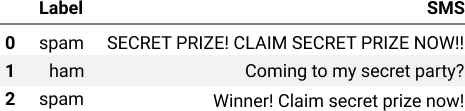

To make the calculations easier, we want bring the data to this format.

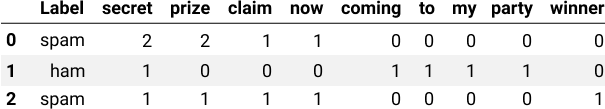

About the transformation above, notice that:

- The SMS column doesn't exist anymore.
- Instead, the SMS column is replaced by a series of new columns, where each column represents a unique word from the vocabulary.
- Each row describes a single message. For instance, the first row corresponds to the message "SECRET PRIZE! CLAIM SECRET PRIZE NOW!!", and it has the values spam, 2, 2, 1, 1, 0, 0, 0, 0, 0. These values tell us that:


    - The message is spam.
    - The word "secret" occurs two times inside the message.
    - The word "prize" occurs two times inside the message.
    - The word "claim" occurs one time inside the message.
    - The word "now" occurs one time inside the message.
    - The words "coming", "to", "my", "party", and "winner" occur zero times inside the message.
    
    
- All words in the vocabulary are in lower case, so "SECRET" and "secret" come to be considered to be the same word.
- Punctuation is not taken into account anymore (for instance, we can't look at the table and conclude that the first message initially had three exclamation marks).

Let's begin the data cleaning process by removing the punctuation and bringing all the words to lower case.

In [12]:
# Before Cleaning
training_set.head()

,Label,SMS
0,ham,"Yep, by the pretty sculpture"
1,ham,"Yes, princess. Are you going to make me moan?"
2,ham,Welp apparently he retired
3,ham,Havent.
4,ham,I forgot 2 ask ü all smth.. There's a card on ...


In [14]:
# Remove all the punctuations from the SMS column
training_set['SMS'] = training_set['SMS'].str.replace('\W', ' ') # '\W' represents any number or letter
training_set.head()

,Label,SMS
0,ham,Yep by the pretty sculpture
1,ham,Yes princess Are you going to make me moan
2,ham,Welp apparently he retired
3,ham,Havent
4,ham,I forgot 2 ask ü all smth There s a card on ...


In [15]:
# Transform every letter in every word to lower case
training_set['SMS'] = training_set['SMS'].str.lower()
training_set.head()

,Label,SMS
0,ham,yep by the pretty sculpture
1,ham,yes princess are you going to make me moan
2,ham,welp apparently he retired
3,ham,havent
4,ham,i forgot 2 ask ü all smth there s a card on ...


## Creating a vocabulary for the messages in the training set

The vocabulary is a Python list containing all the unique words across all messages, where each word is represented as a string.

In [16]:
# Step 1
# Transforming each message from the SMS column into a list by splitting the string at the space character
training_set['SMS'] = training_set['SMS'].str.split()
training_set.head()

,Label,SMS
0,ham,"[yep, by, the, pretty, sculpture]"
1,ham,"[yes, princess, are, you, going, to, make, me,..."
2,ham,"[welp, apparently, he, retired]"
3,ham,[havent]
4,ham,"[i, forgot, 2, ask, ü, all, smth, there, s, a,..."


In [17]:
# Step 2
# Creating the vocabulary

vocabulary = []
for sms in training_set['SMS']:
    for word in sms:
        vocabulary.append(word)
print(len(vocabulary)) 
print(len(set(vocabulary))) # set() removes duplicates

72427
7783


In [18]:
# Transform vocabulary list to set to remove duplicates 
# and then again Transform the vocabulary set back into a list

vocabulary = set(vocabulary)
vocabulary = list(vocabulary)

print(type(vocabulary))
print(len(vocabulary))

<class 'list'>
7783


There are 7,783 unique words in all the messages of our training set.

## The final training set

In [22]:
# Step 1
# Build a dictionary for our training set

"""
1. We start by initializing a dictionary named word_counts_per_sms, where each key is a unique word (a string) from the vocabulary, and each value is a list of the length of training set, where each element in the list is a 0.

2. The code [0] * 5 outputs [0, 0, 0, 0, 0]. So the code [0] * len(training_set['SMS']) outputs a list of the length of training_set['SMS'], where each element in the list will be a 0.

3. We loop over training_set['SMS'] using at the same time the enumerate() function to get both the index and the SMS message (index and sms).
    - Using a nested loop, we loop over sms (where sms is a list of strings, where each string represents a word in a message).
    - We incremenent word_counts_per_sms[word][index] by 1.
    
"""

word_counts_per_sms = {unique_word: [0] * len(training_set['SMS']) for unique_word in vocabulary}

for index, sms in enumerate(training_set['SMS']):
    for word in sms:
        word_counts_per_sms[word][index] += 1 #index hopping
        
print("Type of this object word_counts_per_sms:", type(word_counts_per_sms))
print("Length of this dictionary:", len(word_counts_per_sms))

Type of this object word_counts_per_sms: <class 'dict'>
Length of this dictionary: 7783


In [23]:
# Printing the first key-value pair in the dictionary
dict_pairs = word_counts_per_sms.items()
pairs_iterator = iter(dict_pairs)
first_pair = next(pairs_iterator)
print("First_Pair:", first_pair)

First_Pair: ('hack', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [24]:
# Print the first value in dictionary
first_value = list(word_counts_per_sms.values())[0]
print('First Value: ', first_value)
print('Length of First Value: ', len(first_value)) # 4458 is the no.of rows in the training set

First Value:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [26]:
print("Length (no.of row) of the training set:", len(training_set['SMS']))

Length (no.of row) of the training set: 4458


In [28]:
# Step 2
# Transform word_counts_per_sms dictionary into a DataFrame
word_counts = pd.DataFrame(word_counts_per_sms)
word_counts.head()

,0,00,000,000pes,008704050406,0089,01223585334,02,0207,02072069400,...,zindgi,zoe,zogtorius,zouk,zyada,é,ú1,ü,〨ud,鈥
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0


In [29]:
word_counts.shape

(4458, 7783)

In [30]:
# Step 3
# Concatenate the DataFrame we just built above with the DataFrame containing the training set 
# This way, we'll also have the Label and the SMS columns

final_training_set = pd.concat([training_set, word_counts], axis=1)
final_training_set.head()

,Label,SMS,0,00,000,000pes,008704050406,0089,01223585334,02,...,zindgi,zoe,zogtorius,zouk,zyada,é,ú1,ü,〨ud,鈥
0,ham,"[yep, by, the, pretty, sculpture]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,"[yes, princess, are, you, going, to, make, me,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ham,"[welp, apparently, he, retired]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,[havent],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ham,"[i, forgot, 2, ask, ü, all, smth, there, s, a,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0


In [31]:
final_training_set.columns

Index(['Label', 'SMS', '0', '00', '000', '000pes', '008704050406', '0089',
       '01223585334', '02',
       ...
       'zindgi', 'zoe', 'zogtorius', 'zouk', 'zyada', 'é', 'ú1', 'ü', '〨ud',
       '鈥'],
      dtype='object', length=7785)

## Calculating constants first 

#### P(Spam), P(Ham), NSpam, NHam, NVocabulary

In [32]:
# Seperate spam and ham messages in to two dataframes
spam_messages = final_training_set[final_training_set['Label'] == 'spam']
ham_messages = final_training_set[final_training_set['Label'] == 'ham']

In [33]:
spam_messages.head()

,Label,SMS,0,00,000,000pes,008704050406,0089,01223585334,02,...,zindgi,zoe,zogtorius,zouk,zyada,é,ú1,ü,〨ud,鈥
16,spam,"[freemsg, why, haven, t, you, replied, to, my,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18,spam,"[congrats, 2, mobile, 3g, videophones, r, your...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
56,spam,"[free, message, activate, your, 500, free, tex...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60,spam,"[call, from, 08702490080, tells, u, 2, call, 0...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
61,spam,"[someone, has, conacted, our, dating, service,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
ham_messages.head()

,Label,SMS,0,00,000,000pes,008704050406,0089,01223585334,02,...,zindgi,zoe,zogtorius,zouk,zyada,é,ú1,ü,〨ud,鈥
0,ham,"[yep, by, the, pretty, sculpture]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,"[yes, princess, are, you, going, to, make, me,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ham,"[welp, apparently, he, retired]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,[havent],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ham,"[i, forgot, 2, ask, ü, all, smth, there, s, a,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0


In [35]:
print(spam_messages.shape)
print(ham_messages.shape)


(600, 7785)
(3858, 7785)


In [37]:
# Calculate P(Spam) and P(Ham)
p_spam = len(spam_messages) / len(final_training_set)
print("P(Spam):", p_spam)

p_ham = len(ham_messages) / len(final_training_set)
print("P(Ham):", p_ham)

P(Spam): 0.13458950201884254
P(Ham): 0.8654104979811574


In [38]:
# Calculate NSpam, NHam, NVocabulary
# NSpam is equal to the number of words in all the spam messages 
n_word_per_spam_message = spam_messages['SMS'].apply(len)
n_word_per_spam_message

16      31
18      26
56      24
60      24
61      25
62      32
70      27
71      32
84      28
89      27
98      27
106     29
113     32
142     28
144      6
158     30
159     24
162      8
164     25
165     27
166     29
179     19
181     13
186     21
191     21
200     24
203     27
206     30
218     22
219     24
        ..
4297    25
4298    20
4306    25
4312    13
4318    29
4331    27
4332    24
4350    27
4353    13
4354    29
4357    13
4359    17
4373    24
4377    27
4379    32
4383    33
4387    14
4388    28
4390    30
4392    29
4401    24
4403    25
4407    32
4414    30
4433    36
4437    20
4439    25
4443    25
4449    30
4455    28
Name: SMS, Length: 600, dtype: int64

In [39]:
n_spam = n_word_per_spam_message.sum()
print("n_spam:", n_spam)

n_spam: 15190


In [40]:
# NHam is equal to the number of words in all the non-spam messages 
n_word_per_ham_message = ham_messages['SMS'].apply(len)
n_word_per_ham_message

0         5
1         9
2         4
3         1
4        26
5        15
6        17
7         6
8         4
9         7
10       10
11        2
12        5
13       16
14       12
15        8
17        9
19        8
20       14
21       11
22       11
23        8
24        7
25       11
26        6
27        4
28       33
29       66
30        6
31       18
       ... 
4422     26
4423      8
4424     10
4425     30
4426     10
4427     28
4428      6
4429      8
4430      6
4431      4
4432     19
4434      9
4435      4
4436      7
4438     11
4440      6
4441      6
4442    100
4444      9
4445     11
4446      5
4447     30
4448      8
4450      4
4451     25
4452      6
4453     17
4454     34
4456     27
4457      4
Name: SMS, Length: 3858, dtype: int64

In [41]:
n_ham = n_word_per_ham_message.sum()
print("n_ham:", n_ham)

n_ham: 57237


In [42]:
# NVocabulary is equal to the total number of words in the vocabulary
n_vocabulary = len(vocabulary)
print("n_vocabulary:", n_vocabulary)

n_vocabulary: 7783


In [50]:
# Smoothing parameter
alpha = 1

## Calculating parameters
#### P(wi|Spam) and P(wi|Ham)

In [43]:
# Step 1
# Initialize two dictionaries, where each key-value pair is a unique word (from our vocabulary) represented as a string, and the value is 0

parameters_spam = {unique_word:0 for unique_word in vocabulary}
parameters_ham = {unique_word:0 for unique_word in vocabulary}

In [44]:
len(parameters_spam)

7783

In [45]:
len(parameters_ham)

7783

In [47]:
parameters_spam

{'hack': 0,
 'situation': 0,
 'deposited': 0,
 'thanku': 0,
 '09099726395': 0,
 'children': 0,
 'regalportfolio': 0,
 'complexities': 0,
 'tackle': 0,
 'usual': 0,
 'valid': 0,
 'pobox75ldns7': 0,
 'classes': 0,
 'tobacco': 0,
 'removal': 0,
 '07008009200': 0,
 'natural': 0,
 'rr': 0,
 '526': 0,
 'msgrcvdhg': 0,
 'bluray': 0,
 'indian': 0,
 '42049': 0,
 'delivery': 0,
 'squeeeeeze': 0,
 '09066380611': 0,
 'doubletxt': 0,
 'readers': 0,
 'getting': 0,
 'certainly': 0,
 'cheap': 0,
 'subscribe6gbp': 0,
 'guoyang': 0,
 'swatch': 0,
 '1450': 0,
 'yar': 0,
 'e': 0,
 'witout': 0,
 'helen': 0,
 'hospital': 0,
 'gona': 0,
 'canceled': 0,
 'from': 0,
 'tncs': 0,
 'winds': 0,
 'underdtand': 0,
 '3hrs': 0,
 'wkg': 0,
 'flatter': 0,
 'suite': 0,
 'outgoing': 0,
 'sub': 0,
 'mrt': 0,
 'gopalettan': 0,
 'gossip': 0,
 'liver': 0,
 'choose': 0,
 'ishtamayoo': 0,
 'badrith': 0,
 'browse': 0,
 'movietrivia': 0,
 'jeetey': 0,
 '5ish': 0,
 'proof': 0,
 'dislikes': 0,
 'three': 0,
 'terrible': 0,
 'specifi

In [48]:
parameters_ham

{'hack': 0,
 'situation': 0,
 'deposited': 0,
 'thanku': 0,
 '09099726395': 0,
 'children': 0,
 'regalportfolio': 0,
 'complexities': 0,
 'tackle': 0,
 'usual': 0,
 'valid': 0,
 'pobox75ldns7': 0,
 'classes': 0,
 'tobacco': 0,
 'removal': 0,
 '07008009200': 0,
 'natural': 0,
 'rr': 0,
 '526': 0,
 'msgrcvdhg': 0,
 'bluray': 0,
 'indian': 0,
 '42049': 0,
 'delivery': 0,
 'squeeeeeze': 0,
 '09066380611': 0,
 'doubletxt': 0,
 'readers': 0,
 'getting': 0,
 'certainly': 0,
 'cheap': 0,
 'subscribe6gbp': 0,
 'guoyang': 0,
 'swatch': 0,
 '1450': 0,
 'yar': 0,
 'e': 0,
 'witout': 0,
 'helen': 0,
 'hospital': 0,
 'gona': 0,
 'canceled': 0,
 'from': 0,
 'tncs': 0,
 'winds': 0,
 'underdtand': 0,
 '3hrs': 0,
 'wkg': 0,
 'flatter': 0,
 'suite': 0,
 'outgoing': 0,
 'sub': 0,
 'mrt': 0,
 'gopalettan': 0,
 'gossip': 0,
 'liver': 0,
 'choose': 0,
 'ishtamayoo': 0,
 'badrith': 0,
 'browse': 0,
 'movietrivia': 0,
 'jeetey': 0,
 '5ish': 0,
 'proof': 0,
 'dislikes': 0,
 'three': 0,
 'terrible': 0,
 'specifi

Formulas for P(wi|Spam) and P(wi|Ham) 

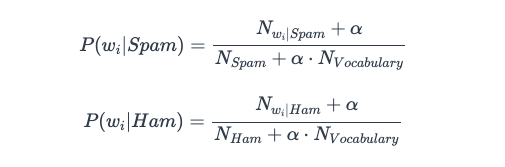

In [51]:
# Calculate parameters

# We have already isolate the spam and the ham messages in the training set into two different DataFrames 
#   - spam_messages, ham_messages

# Iterate over the vocabulary, and, for each word, 
# calculate P(wi|Spam) and P(wi|Ham) using the formulas we mentioned above.

# Recall that NSpam, NHam, NVocabulary, and α are already calculated from the last screen.

# Recall that Nwi|Spam is equal to the number of times the word wi occurs in all the spam messages, while Nwi|Ham is equal to the number of times the word wi occurs in all the ham messages.

# Once done with calculating an individual parameter, update the probability value in the two dictionaries you created initially.


for word in vocabulary:
    n_word_given_spam = spam_messages[word].sum() # spam_messages already defined in a cell above
    p_word_given_spam = (n_word_given_spam + alpha) / (n_spam + alpha * n_vocabulary)
    parameters_spam[word] = p_word_given_spam
    
    n_word_given_ham = ham_messages[word].sum() # ham_messages already definded in a cell above
    p_word_given_ham = (n_word_given_ham + alpha) / (n_ham + alpha * n_vocabulary)
    parameters_ham[word] = p_word_given_ham

In [52]:
parameters_spam

{'hack': 8.705872110738693e-05,
 'situation': 4.3529360553693465e-05,
 'deposited': 4.3529360553693465e-05,
 'thanku': 4.3529360553693465e-05,
 '09099726395': 8.705872110738693e-05,
 'children': 0.0001305880816610804,
 'regalportfolio': 8.705872110738693e-05,
 'complexities': 4.3529360553693465e-05,
 'tackle': 4.3529360553693465e-05,
 'usual': 4.3529360553693465e-05,
 'valid': 0.0009576459321812563,
 'pobox75ldns7': 8.705872110738693e-05,
 'classes': 4.3529360553693465e-05,
 'tobacco': 4.3529360553693465e-05,
 'removal': 0.0001305880816610804,
 '07008009200': 8.705872110738693e-05,
 'natural': 4.3529360553693465e-05,
 'rr': 4.3529360553693465e-05,
 '526': 8.705872110738693e-05,
 'msgrcvdhg': 0.0001305880816610804,
 'bluray': 4.3529360553693465e-05,
 'indian': 4.3529360553693465e-05,
 '42049': 8.705872110738693e-05,
 'delivery': 0.0008270578505201758,
 'squeeeeeze': 4.3529360553693465e-05,
 '09066380611': 0.0001305880816610804,
 'doubletxt': 8.705872110738693e-05,
 'readers': 8.70587211

In [53]:
parameters_ham

{'hack': 1.537988311288834e-05,
 'situation': 0.00012303906490310673,
 'deposited': 3.075976622577668e-05,
 'thanku': 3.075976622577668e-05,
 '09099726395': 1.537988311288834e-05,
 'children': 0.0001076591817902184,
 'regalportfolio': 1.537988311288834e-05,
 'complexities': 3.075976622577668e-05,
 'tackle': 3.075976622577668e-05,
 'usual': 0.00016917871424177176,
 'valid': 1.537988311288834e-05,
 'pobox75ldns7': 1.537988311288834e-05,
 'classes': 4.6139649338665025e-05,
 'tobacco': 3.075976622577668e-05,
 'removal': 1.537988311288834e-05,
 '07008009200': 1.537988311288834e-05,
 'natural': 6.151953245155337e-05,
 'rr': 3.075976622577668e-05,
 '526': 1.537988311288834e-05,
 'msgrcvdhg': 1.537988311288834e-05,
 'bluray': 3.075976622577668e-05,
 'indian': 7.689941556444171e-05,
 '42049': 1.537988311288834e-05,
 'delivery': 1.537988311288834e-05,
 'squeeeeeze': 3.075976622577668e-05,
 '09066380611': 1.537988311288834e-05,
 'doubletxt': 1.537988311288834e-05,
 'readers': 1.537988311288834e-0

## Classifying new message

Now that we've calculated all the constants and parameters we need, we can start creating the spam filter. The spam filter can be understood as a function that:

1. Takes in as input a new message (w1, w2, ..., wn)

2. Calculates P(Spam|w1, w2, ..., wn) and P(Ham|w1, w2, ..., wn)

3. Compares the values of P(Spam|w1, w2, ..., wn) and P(Ham|w1, w2, ..., wn), and:

    - If P(Ham|w1, w2, ..., wn) > P(Spam|w1, w2, ..., wn), then the message is classified as ham.
    - If P(Ham|w1, w2, ..., wn) < P(Spam|w1, w2, ..., wn), then the message is classified as spam.
    - If P(Ham|w1, w2, ..., wn) = P(Spam|w1, w2, ..., wn), then the algorithm may request human help.

In [54]:
# Spam filter function

import re

def classify(message):

    message = re.sub('\W', ' ', message)
    message = message.lower()
    message = message.split()
    
    p_spam_given_message = p_spam
    p_ham_given_message = p_ham

    for word in message:
        if word in parameters_spam:
            p_spam_given_message *= parameters_spam[word] #update the value of p_spam_given_message by multiplying with the parameter value specific to that word. 
            
        if word in parameters_ham:
            p_ham_given_message *= parameters_ham[word] #update the value of p_ham_given_message by multiplying with the parameter value specific to that word. 
            

    print('P(Spam|message):', p_spam_given_message)
    print('P(Ham|message):', p_ham_given_message)

    if p_ham_given_message > p_spam_given_message:
        print('Label: Ham')
    elif p_ham_given_message < p_spam_given_message:
        print('Label: Spam')
    else:
        print('Equal proabilities, have a human classify this!')

#### Using the classify() function now

In [55]:
classify('WINNER!! This is the secret code to unlock the money: C3421.')

P(Spam|message): 1.3481290211300841e-25
P(Ham|message): 1.9368049028589875e-27
Label: Spam


In [56]:
classify("Sounds good, Tom, then see u there")

P(Spam|message): 2.4372375665888117e-25
P(Ham|message): 3.687530435009238e-21
Label: Ham


## Measuring the Spam Filter's accuracy

First off, we'll change the classify() function that we wrote previously to return the labels instead of printing them.

In [57]:
def classify_test_set(message):

    message = re.sub('\W', ' ', message)
    message = message.lower()
    message = message.split()

    p_spam_given_message = p_spam
    p_ham_given_message = p_ham

    for word in message:
        if word in parameters_spam:
            p_spam_given_message *= parameters_spam[word]

        if word in parameters_ham:
            p_ham_given_message *= parameters_ham[word]

    if p_ham_given_message > p_spam_given_message:
        return 'ham'
    elif p_spam_given_message > p_ham_given_message:
        return 'spam'
    else:
        return 'needs human classification'

Now that we have a function that returns labels instead of printing them, we can use it to create a new column in our test set.

In [58]:
test_set['predicted'] = test_set['SMS'].apply(classify_test_set)
test_set.head()

,Label,SMS,predicted
0,ham,Later i guess. I needa do mcat study too.,ham
1,ham,But i haf enuff space got like 4 mb...,ham
2,spam,Had your mobile 10 mths? Update to latest Oran...,spam
3,ham,All sounds good. Fingers . Makes it difficult ...,ham
4,ham,"All done, all handed in. Don't know if mega sh...",ham


In [59]:
test_set.shape

(1114, 3)

Now we can compare the predicted values with the actual values to measure how good our spam filter is with classifying new messages. 

To make the measurement, we'll use accuracy as a metric:

Accuracy = number of correctly classified messages / total number of classified messages

In [60]:
# Measure the accuracy of the spam filter.

correct = 0
total = 1114

for row in test_set.iterrows(): #Iterate over DataFrame rows as (index, Series) pairs.
    row = row[1]
    if row['Label'] == row['predicted']:
        correct += 1
        
print('Correct:', correct)
print('Incorrect:', total - correct)
print('Accuracy:', correct/total)

Correct: 1100
Incorrect: 14
Accuracy: 0.9874326750448833


The accuracy is close to 98.74%, which is really good. Our spam filter looked at 1,114 messages that it hasn't seen in training, and classified 1,100 correctly.

## Conclusion

In this project, we managed to build a spam filter for SMS messages using the multinomial Naive Bayes algorithm. The filter had an accuracy of 98.74% on the test set, which is an excellent result. We initially aimed for an accuracy of over 80%, but we managed to do way better than that.